In [260]:
import sncosmo
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [261]:
from scipy.integrate import cumulative_trapezoid as cumtrapz
import astropy.constants as c
import astropy.units as u
import astropy.cosmology.units as cu
from scipy import interpolate
from astropy.cosmology import WMAP9 as cosmo
import extinction
import math
import scipy.stats as stats

# DAY_CGS = 86400.0
# M_SUN_CGS = c.M_sun.cgs.value
# C_CGS = c.c.cgs.value
# beta = 13.7
# KM_CGS = u.km.cgs.scale
# RAD_CONST = KM_CGS * DAY_CGS
# STEF_CONST = 4. * np.pi * c.sigma_sb.cgs.value
# ANG_CGS = u.Angstrom.cgs.scale
# MPC_CGS = u.Mpc.cgs.scale

# DIFF_CONST = 2.0 * M_SUN_CGS / (beta * C_CGS * KM_CGS)
# TRAP_CONST = 3.0 * M_SUN_CGS / (4. * np.pi * KM_CGS ** 2)
# FLUX_CONST = 4.0 * np.pi * (
#         2.0 * c.h * c.c ** 2 * np.pi).cgs.value * u.Angstrom.cgs.scale
# X_CONST = (c.h * c.c / c.k_B).cgs.value

DAY_CGS = u.day
M_SUN_CGS = c.M_sun
C_CGS = c.c
beta = 13.7
KM_CGS = u.km
# RAD_CONST = KM_CGS * DAY_CGS
RAD_CONST = 1

STEF_CONST = 4. * np.pi * c.sigma_sb
ANG_CGS = u.Angstrom
MPC_CGS = u.Mpc

DIFF_CONST = 2.0 * M_SUN_CGS / (beta * C_CGS * KM_CGS)
TRAP_CONST = 3.0 * M_SUN_CGS / (4. * np.pi * KM_CGS ** 2)
FLUX_CONST = 4.0 * np.pi * (
        2.0 * c.h * c.c ** 2 * np.pi) * u.Angstrom
X_CONST = (c.h * c.c / c.k_B)

In [262]:
class ArnettSource(sncosmo.Source):

    _param_names = ['mej', 'fni', 'vej']
    param_names = ['mej', 'fni', 'vej']

    param_names_latex = ['M_{ej}', 'f_{Ni}', 'v_{ej}']   # used in plotting display

    def __init__(self, phase, wave, params=None, name=None, version=None):
        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        self._tfloor = 3000 * u.K
        if params is not None:
            self._parameters = params
        else:
            self._parameters = [0, 0, 0]

    def _blackbody_flux(self, temperature, radius, wavelength):
    # Convert wavelength from Angstrom to cm
        # wavelength_cm = wavelength
        wavelength_cm = wavelength.to(u.cm)

        all_fluxes = np.zeros((len(temperature), len(wavelength)))
        for i in range(len(temperature)):
            temp = temperature[i]
            rad = radius[i]
            
            # Calculate the black body flux density using Planck's law
            numerator = (4 * np.pi) * 2 * c.h * c.c**2 / wavelength_cm**5
            exponent = c.h * c.c / (wavelength_cm * c.k_B * temp)
            denominator = np.exp(exponent.value) - 1
            flux_density_erg_per_s_per_cm2_per_cm= numerator / denominator
            flux_density_erg_per_s_per_per_angstrom = flux_density_erg_per_s_per_cm2_per_cm * 4. * np.pi * rad**2
            # print(flux_density_erg_per_s_per_per_angstrom.decompose(bases=[u.erg, u.AA, u.s, u.g]))
            all_fluxes[i,:] = flux_density_erg_per_s_per_per_angstrom # current using erg/s/Angstroms
        return all_fluxes 


    def _gen_arnett_model(self, t, wvs, theta):
        mej, fni, vej = theta
        mej = (mej * u.Msun).to(u.g)
        vej = vej * u.km/u.s
        t = t * u.day
        wvs = wvs * u.AA
        tfloor = self._tfloor
        # Convert to grams
        # mej = mej * M_SUN_CGS
        mni = mej * fni
        # Convert velocity to cm/s
        # vej = vej * 1e8
        vej = vej.to(u.cm / u.s)

        tni = 8.8 * u.day  # days
        tco = 111.3  * u.day # days
        epco = 6.8e9 * u.erg / u.g / u.s # erg/g/s
        epni = 3.9e10 * u.erg / u.g / u.s # erg/g/s
        opac = 0.1 *u.cm * u.cm/u.g
        texp = 0 * u.day
        # Diffusion timescale in days
        td = np.sqrt(2 * opac * mej / (13.7 * c.c * vej)).to(u.day)  # convert seconds to days
        t_to_integrate = np.hstack((np.array(0.), t))

        
        # td = np.sqrt(2 * opac * mej / (13.7 * C_CGS * vej)) / 86400  # convert seconds to days
        integrand1 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tni)
        integrand2 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tco)

        print(t[:10])

        print(t_to_integrate[:10])
        
        # Luminosity calculation
        luminosities = 2 * mni / (td) * np.exp(-t_to_integrate**2 / td**2) * \
              (((epni - epco) * cumtrapz(integrand1, t_to_integrate, initial=0) + 
               epco * cumtrapz(integrand2, t_to_integrate, initial=0)))*u.day # these should be erg/s
        
        print(luminosities)
        luminosities = luminosities[1:]
        
        #Do BB calculation
        radius = (RAD_CONST * vej * ((t - texp) * ((t-texp)>=0))).to(u.cm)
        temperature = ((luminosities / (STEF_CONST * radius**2))**0.25).to(u.K)# * (1e52)**0.25
        gind = (temperature < tfloor) | np.isnan(temperature)
        temperature = np.nan_to_num(temperature)
        notgind = np.invert(gind)
        temperature = (0. * temperature) + (temperature * notgind) + (tfloor * gind)
        print(temperature)
        
        radius = np.sqrt(luminosities / (STEF_CONST * temperature**4))
        print(radius)
        radius = radius.to(u.cm)
        print(radius)

        fluxes = self._blackbody_flux(temperature, radius, wvs) # this is a luminosity density

        fluxes = u.Quantity(fluxes, u.erg / (u.AA * u.s), copy=False)
        # print(fluxes)
        
        # divide luminosity density by 4pir^2 to get flux
        z = 0.25 * cu.redshift
        d_cm = z.to(u.cm, cu.redshift_distance(cosmo, kind="comoving"))
        # print(d_cm.to(u.Mpc))
        flux_density = fluxes / (4 * np.pi * d_cm**2) 
        return flux_density


    def _flux(self, phase, wave):
        return self._gen_arnett_model(phase, wave, self._parameters)

In [263]:
times = np.linspace(0.1,200,100) # days
wavelengths = np.linspace(2000,12000,10) # Angstroms
mej = 3
fni = 0.1
vej = 10000
arnett_source = ArnettSource(times, wavelengths, params=[mej, fni, vej])

In [264]:
max_flux = arnett_source.flux(times, wavelengths)

[ 0.1         2.11919192  4.13838384  6.15757576  8.17676768 10.1959596
 12.21515152 14.23434343 16.25353535 18.27272727] d
[ 0.          0.1         2.11919192  4.13838384  6.15757576  8.17676768
 10.1959596  12.21515152 14.23434343 16.25353535] d
[0.00000000e+00 5.92194116e+38 2.22189655e+41 7.59831347e+41
 1.47167618e+42 2.24477053e+42 2.99342234e+42 3.65732782e+42
 4.19910643e+42 4.60114849e+42 4.86188815e+42 4.99175814e+42
 5.00915037e+42 4.93670056e+42 4.79815294e+42 4.61596270e+42
 4.40968698e+42 4.19511777e+42 3.98403889e+42 3.78444941e+42
 3.60108625e+42 3.43609388e+42 3.28971988e+42 3.16095158e+42
 3.04804566e+42 2.94893238e+42 2.86149794e+42 2.78376191e+42
 2.71397235e+42 2.65064206e+42 2.59254669e+42 2.53870094e+42
 2.48832488e+42 2.44080791e+42 2.39567503e+42 2.35255753e+42
 2.31116877e+42 2.27128492e+42 2.23272994e+42 2.19536412e+42
 2.15907544e+42 2.12377305e+42 2.08938237e+42 2.05584145e+42
 2.02309814e+42 1.99110806e+42 1.95983292e+42 1.92923934e+42
 1.89929786e+42 1.8

In [265]:
max_flux[9][9]

<Quantity 9.0454071e-19 erg / (Angstrom s cm2)>

In [266]:
max_flux.shape

(100, 10)

In [267]:
max_flux[9][9]

<Quantity 9.0454071e-19 erg / (Angstrom s cm2)>

In [268]:
# Calculate magnitude from flux
def get_magnitude(flux):
    fnu = ((wavelengths * u.AA)**2 * flux / c.c)
    m = -2.5*np.log10(fnu.to(u.Jy)[9]/(3631*u.Jy))
    dpc =1020536167.755819 # z = 0.25 in pc
    return m - 5*(np.log10(dpc) - 1)


In [269]:
# Convert f_lambda to f_nu
fnu = ((wavelengths * u.AA)**2 * max_flux[9][9] / c.c)

In [270]:
fnu

<Quantity [1.20688921e-20, 2.92037390e-20, 5.37885193e-20, 8.58232330e-20,
           1.25307880e-19, 1.72242461e-19, 2.26626975e-19, 2.88461422e-19,
           3.57745803e-19, 4.34480117e-19] Angstrom erg / (m cm2)>

In [271]:
fnu.to(u.Jy)[9]

<Quantity 4.34480117e-06 Jy>

In [272]:
# Apparent magnitude
m = -2.5*np.log10(fnu.to(u.Jy)[9]/(3631*u.Jy))
m

<Quantity 22.30514086>

In [273]:
# Absolute magnitude
dpc =1020536167.755819 # this is comoving distance for z = 0.25
m - 5*(np.log10(dpc) - 1)

<Quantity -17.73900115>

In [274]:
arnett_source = ArnettSource(times, wavelengths, params=[mej, fni, vej])
model = sncosmo.Model(source=arnett_source)
print(arnett_source)

class      : ArnettSource
name       : None
version    : None
phases     : [0.1, .., 200] days
wavelengths: [2000, .., 12000] Angstroms
parameters:
  mej = 3
  fni = 0.1
  vej = 10000


Text(0.5, 0, 'Days')

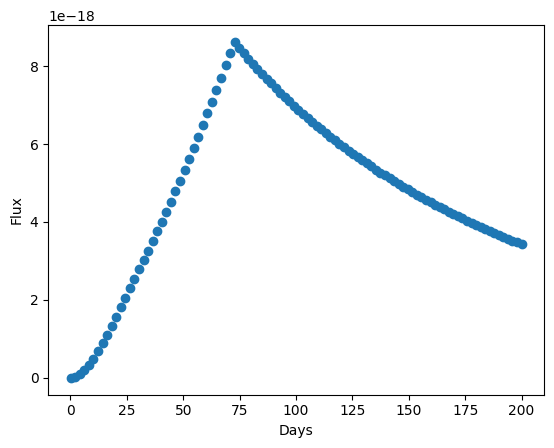

In [275]:
plt.plot(times, max_flux[:,8], 'o')
plt.ylabel("Flux")
plt.xlabel("Days")

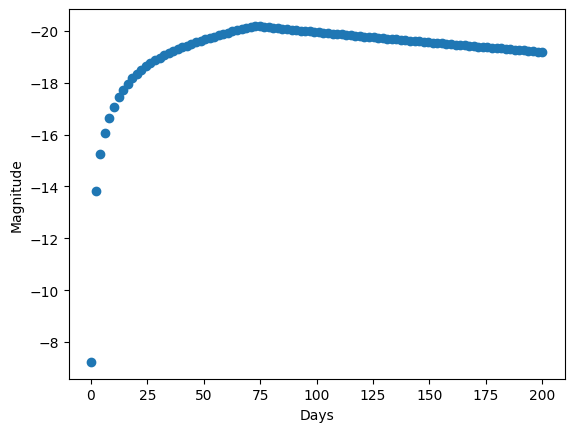

In [276]:
plt.plot(times, [get_magnitude(i) for i in max_flux[:,8]], 'o')
plt.ylabel("Magnitude")
plt.xlabel("Days")
plt.gca().invert_yaxis()

In [277]:
# This is sample data from SNCosmo... right now I'm only using it to get the band names
data = sncosmo.load_example_data()

In [284]:
params = {'mej':3, 'fni': 0.1, 'vej': 10000}
obs = Table({'time': np.array([50, 100, 150,200] * 4),
             'band': np.repeat(np.unique(np.array(data['band'])), 4),
            'zp': 25. * np.ones(16), 'zpsys':['ab', 'ab', 'ab', 'ab']*4, 
             'gain':np.ones(16), 'skynoise':100*np.ones(16)})

In [285]:
lcs = sncosmo.realize_lcs(obs, model, [params])

[ 50. 100. 150. 200.] d
[  0.  50. 100. 150. 200.] d
[0.00000000e+00 1.70502795e+43 2.12263158e+43 2.03145269e+43
 1.72840014e+43] erg / s
[5983.91756446 4469.47367742 3609.47283084 3002.15978952] K
[1.36610395e+17 2.73220790e+17 4.09831185e+17 5.46441580e+17] m erg(1/2) / (W(1/2) s(1/2))
[4.320e+15 8.640e+15 1.296e+16 1.728e+16] cm
[ 50. 100. 150. 200.] d
[  0.  50. 100. 150. 200.] d
[0.00000000e+00 1.70502795e+43 2.12263158e+43 2.03145269e+43
 1.72840014e+43] erg / s
[5983.91756446 4469.47367742 3609.47283084 3002.15978952] K
[1.36610395e+17 2.73220790e+17 4.09831185e+17 5.46441580e+17] m erg(1/2) / (W(1/2) s(1/2))
[4.320e+15 8.640e+15 1.296e+16 1.728e+16] cm
[ 50. 100. 150. 200.] d
[  0.  50. 100. 150. 200.] d
[0.00000000e+00 1.70502795e+43 2.12263158e+43 2.03145269e+43
 1.72840014e+43] erg / s
[5983.91756446 4469.47367742 3609.47283084 3002.15978952] K
[1.36610395e+17 2.73220790e+17 4.09831185e+17 5.46441580e+17] m erg(1/2) / (W(1/2) s(1/2))
[4.320e+15 8.640e+15 1.296e+16 1.728e+16

In [286]:
lcs

[<Table length=16>
  time  band         flux             fluxerr          zp   zpsys
 int64  str5       float64            float64       float64  str2
 ----- ----- ------------------- ------------------ ------- -----
    50 sdssg  304.29542358943945 102.40988260710476    25.0    ab
   100 sdssg  1264.4276972976152 106.97810334900852    25.0    ab
   150 sdssg    2569.22269960492 112.25985232297774    25.0    ab
   200 sdssg  3678.7843972684245 117.53154555627712    25.0    ab
    50 sdssi  311.70662552446623 100.94732073372826    25.0    ab
   100 sdssi   621.7582232307251 102.78913376352222    25.0    ab
   ...   ...                 ...                ...     ...   ...
   100 sdssr   815.3759347219901 104.07182441223387    25.0    ab
   150 sdssr  1420.4195965702402 107.23963508935488    25.0    ab
   200 sdssr  2130.8501019379923 110.47046468438188    25.0    ab
    50 sdssz -130.56741485001461 100.67530285446162    25.0    ab
   100 sdssz   407.7393606147501 101.99509951253627    25

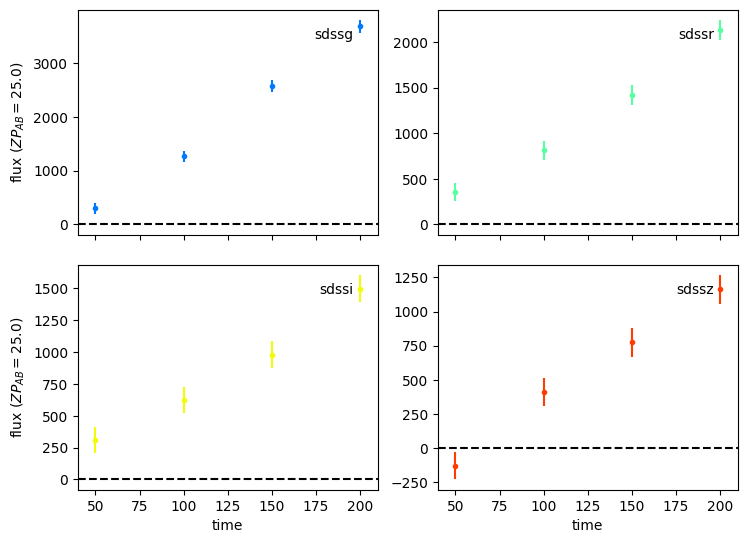

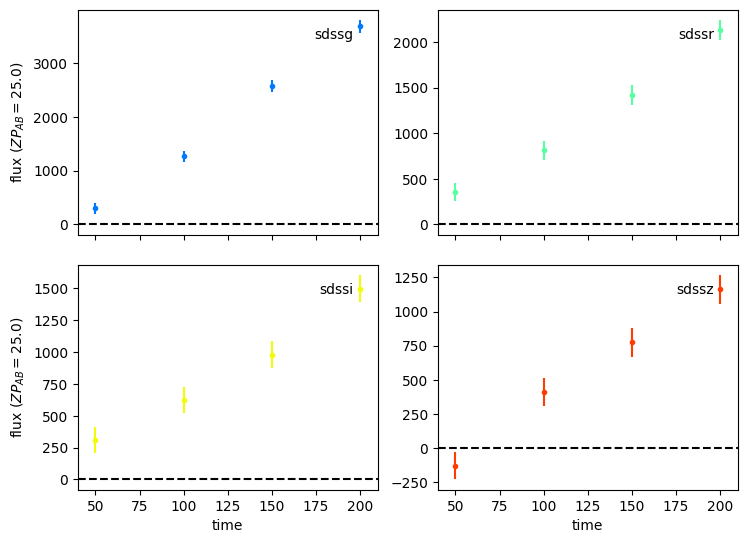

In [287]:
sncosmo.plot_lc(lcs[0])

In [288]:
result, fitted_model = sncosmo.mcmc_lc(lcs[0], model, ['mej', 'vej', 'fni'], 
                                      bounds={'mej':(2.5, 3.5), 'fni':(0.01, 0.3), 'vej':(5000, 15000)})

[0.1        1.10452261 2.10904523 3.11356784 4.11809045 5.12261307
 6.12713568 7.13165829 8.1361809  9.14070352] d
[0.         0.1        1.10452261 2.10904523 3.11356784 4.11809045
 5.12261307 6.12713568 7.13165829 8.1361809 ] d
[0.00000000e+00 5.92194116e+38 6.62803563e+40 2.28960641e+41
 4.68549210e+41 7.66817376e+41 1.10733335e+42 1.47541404e+42
 1.85808101e+42 2.24401566e+42 2.62350958e+42 2.98840699e+42
 3.33203726e+42 3.64913634e+42 3.93575703e+42 4.18916848e+42
 4.40774645e+42 4.59085597e+42 4.73872878e+42 4.85233806e+42
 4.93327288e+42 4.98361527e+42 5.00582201e+42 5.00261359e+42
 4.97687201e+42 4.93154897e+42 4.86958548e+42 4.79384345e+42
 4.70704956e+42 4.61175116e+42 4.51028366e+42 4.40474871e+42
 4.29700209e+42 4.18865008e+42 4.08105319e+42 3.97533576e+42
 3.87240032e+42 3.77294532e+42 3.67748525e+42 3.58637193e+42
 3.49981633e+42 3.41791001e+42 3.34064563e+42 3.26793615e+42
 3.19963234e+42 3.13553841e+42 3.07542572e+42 3.01904447e+42
 2.96613355e+42 2.91642854e+42 2.86966

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


[0.1        1.10430622 2.10861244 3.11291866 4.11722488 5.1215311
 6.12583732 7.13014354 8.13444976 9.13875598] d
[0.         0.1        1.10430622 2.10861244 3.11291866 4.11722488
 5.1215311  6.12583732 7.13014354 8.13444976] d
[0.00000000e+00 5.92263263e+38 6.62813537e+40 2.29835834e+41
 4.73290238e+41 7.81392212e+41 1.14122589e+42 1.54188425e+42
 1.97418433e+42 2.43042003e+42 2.90414766e+42 3.39000022e+42
 3.88352676e+42 4.38105357e+42 4.87956446e+42 5.37659774e+42
 5.87015755e+42 6.35863794e+42 6.84075780e+42 7.31550533e+42
 7.78209077e+42 8.23990627e+42 8.68849195e+42 9.12750724e+42
 9.55670695e+42 9.97592113e+42 1.03850385e+43 1.07839927e+43
 1.11727511e+43 1.15513055e+43 1.19196652e+43 1.22778509e+43
 1.26258902e+43 1.29638147e+43 1.32916567e+43 1.36094484e+43
 1.39172199e+43 1.42149990e+43 1.45028111e+43 1.47806790e+43
 1.50486234e+43 1.53066633e+43 1.55548170e+43 1.57931022e+43
 1.60215377e+43 1.62401435e+43 1.64489419e+43 1.66479585e+43
 1.68372228e+43 1.70167689e+43 1.718663

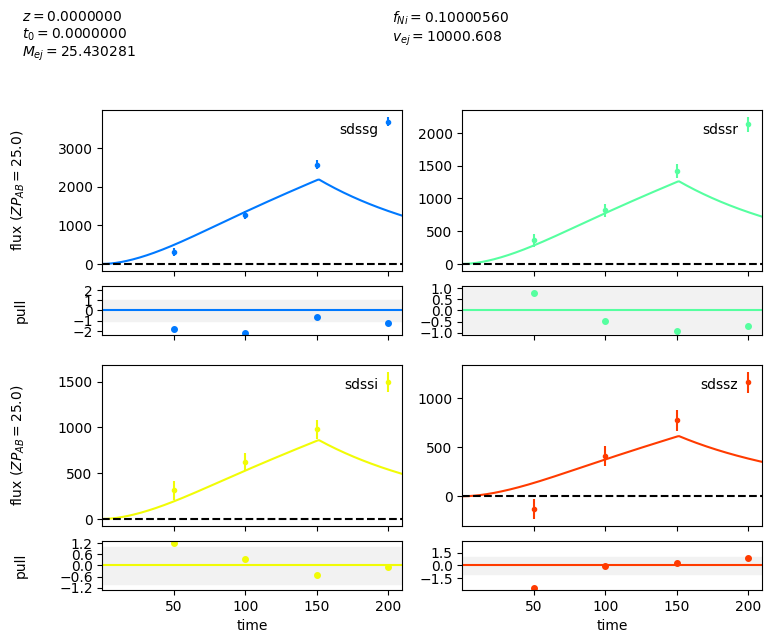

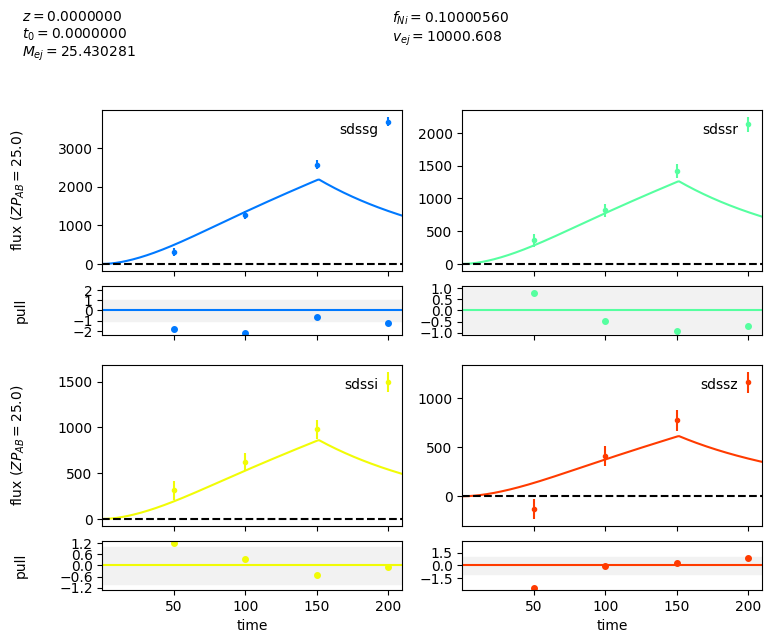

In [289]:
sncosmo.plot_lc(lcs[0], model=fitted_model)

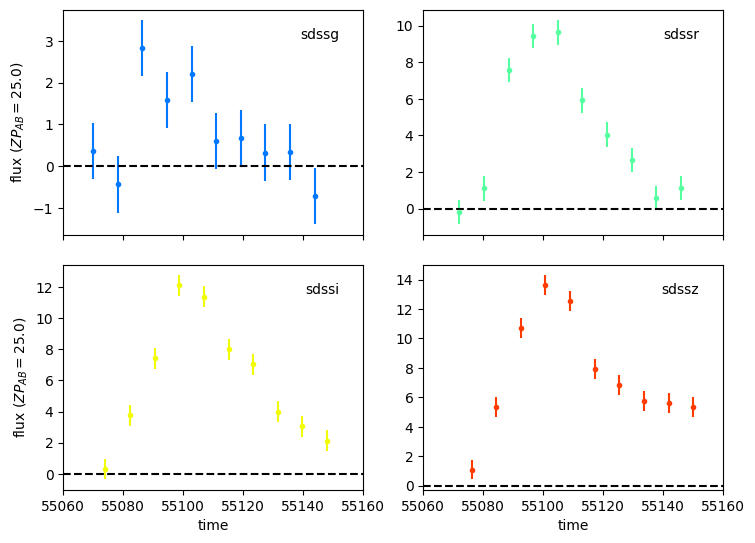

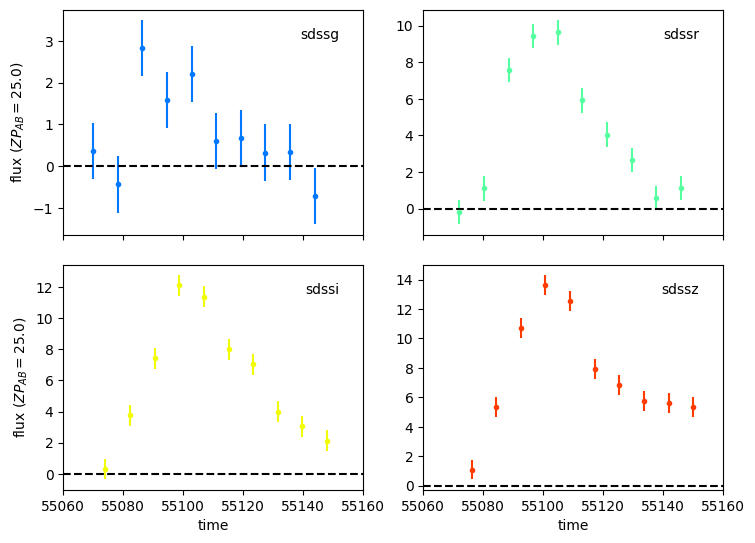

In [174]:
sncosmo.plot_lc(data)

In [932]:
model = sncosmo.Model(source='salt2')
result, fitted_model = sncosmo.fit_lc(
    data, model,
    ['z', 't0', 'x0', 'x1', 'c'],  # parameters of model to vary
    bounds={'z':(0.3, 0.7)}) 

In [14]:
model.param_names

['z', 't0', 'x0', 'x1', 'c']

In [15]:
model = sncosmo.Model(source='nugent-sn1a')
model.param_names

['z', 't0', 'amplitude']

In [16]:
model = sncosmo.Model(source='nugent-sn1bc')
model.param_names

['z', 't0', 'amplitude']

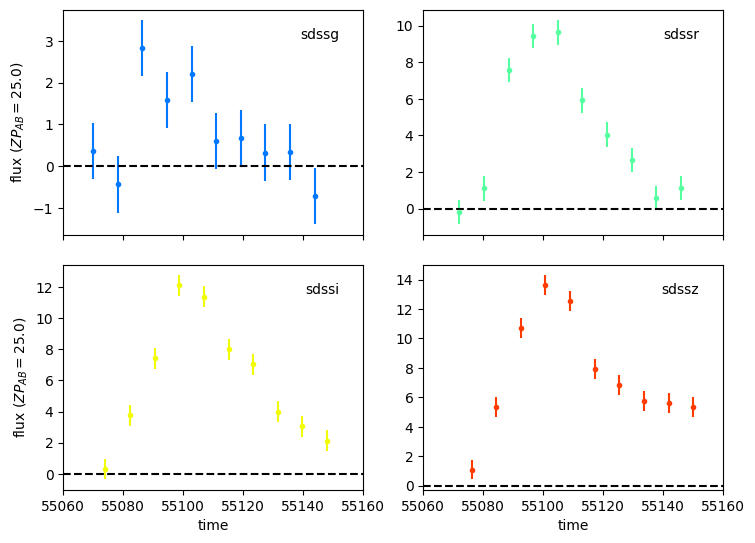

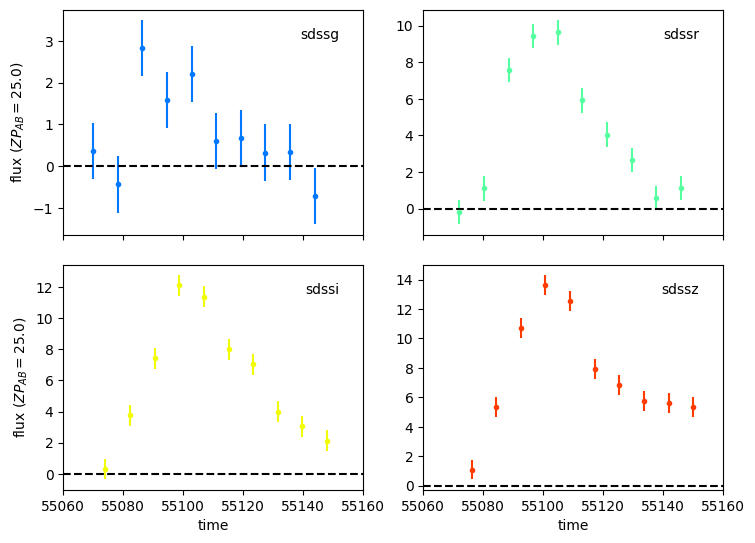

In [18]:
sncosmo.plot_lc(data)

## Arnett Model

In [49]:
t_Ni = 8.8 # days
t_Co = 111.3
t_d = 10

def integral(tprime, t_d, other_time):
    return (tprime / t_d) * np.exp(tprime**2 / t_d**2) * np.exp(-tprime/other_time)

In [50]:
eps_Ni = 3.9e10 # erg/s/g
eps_Co = 6.8e9 # erg/s/g

def arnett(t, t_d, Mni):
    Ni_integral, _ = integrate.quad(integral, 0, t, args=(t_d, t_Ni,))
    Co_integral, _ = integrate.quad(integral, 0, t, args=(t_d, t_Co,))
    
    return (2 * Mni / t_d) * np.exp(-t**2 / t_d**2) * ((eps_Ni - eps_Co) * Ni_integral + eps_Co * Co_integral)

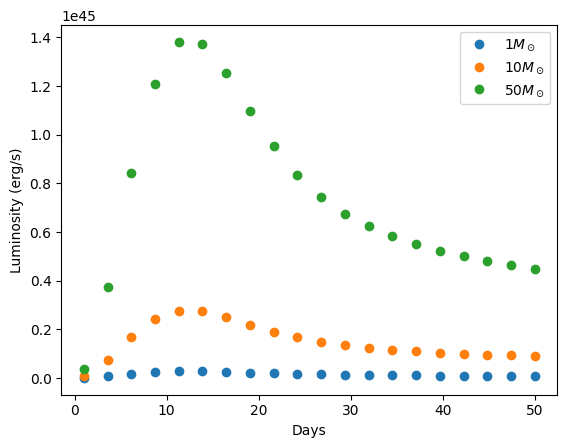

In [51]:
Msun = 2e33 # grams

times = np.linspace(1, 50, 20)
plt.plot(times, [arnett(i, 10, 1*Msun) for i in times], 'o', label="$1 M_\odot$")
plt.plot(times, [arnett(i, 10, 10*Msun) for i in times], 'o', label="$10 M_\odot$")
plt.plot(times, [arnett(i, 10, 50*Msun) for i in times], 'o', label="$50 M_\odot$")

plt.xlabel("Days")
plt.ylabel("Luminosity (erg/s)")
plt.legend()
plt.show()